In [1]:
import numpy as np
import pandas as pd
import os
import shutil

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import v2
from torchvision import transforms, models

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
df_total_train = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')
df_total_val = pd.read_csv('./eda/df_total_val_shuffled_v1.csv')
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')

In [3]:
# df_total_train = df_total_train[:25000]

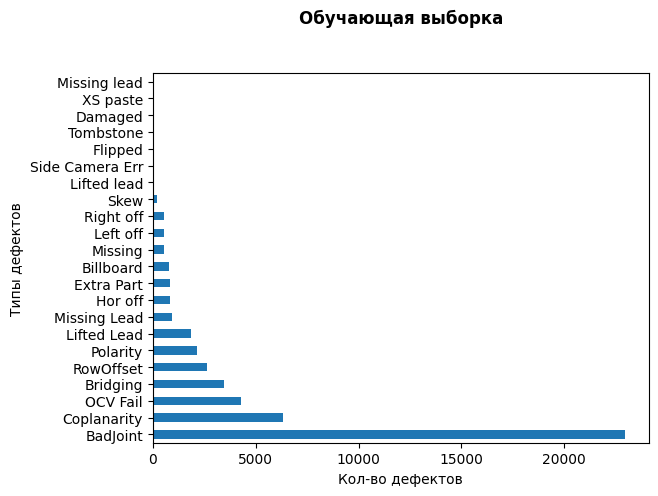

In [4]:
dist1 = df_total_train['indictmentType'].value_counts() #.sort_values()

# plt.bar(dist1, orientation='horizontal', histtype ='bar', bins=22)
ax = df_total_train['indictmentType'].value_counts().plot(kind='barh')

plt.ylabel('Типы дефектов')
plt.xlabel('Кол-во дефектов')
 
plt.title('Обучающая выборка\n\n',
          fontweight = "bold")

plt.show()

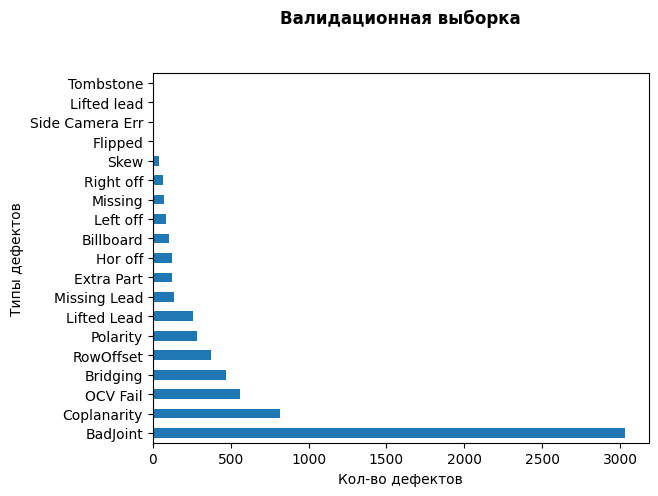

In [5]:
dist2 = df_total_val['indictmentType'].sort_values()

ax = df_total_val['indictmentType'].value_counts().plot(kind='barh')

plt.ylabel('Типы дефектов')
plt.xlabel('Кол-во дефектов')
 
plt.title('Валидационная выборка\n\n',
          fontweight = "bold")

plt.show()

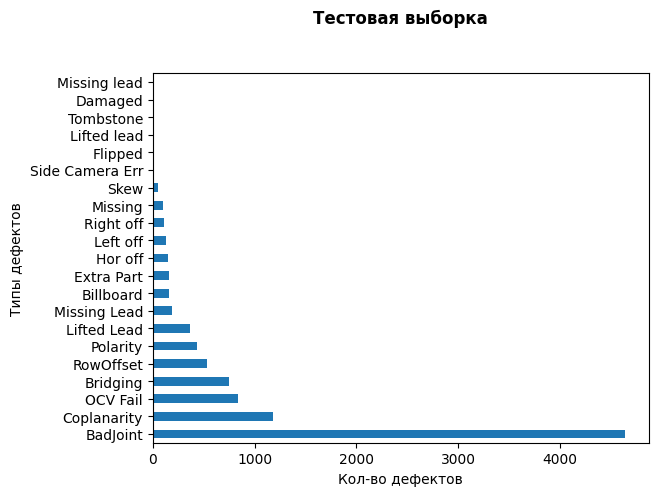

In [6]:
dist3 = df_total_test['indictmentType'].sort_values()

ax = df_total_test['indictmentType'].value_counts().plot(kind='barh')

plt.ylabel('Типы дефектов')
plt.xlabel('Кол-во дефектов')
 
plt.title('Тестовая выборка\n\n',
          fontweight = "bold")

plt.show()

In [7]:
train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
train_y = (df_total_train['repairStatus']).tolist()

val_X = (df_total_val['img_folder'] + df_total_val['defect_image']).tolist()
val_y = (df_total_val['repairStatus']).tolist()

test_X = (df_total_test['img_folder'] + df_total_test['defect_image']).tolist()
test_y = (df_total_test['repairStatus']).tolist()

In [8]:
class image(Dataset):

    def __init__(self, X, Y, transform=None):
        self.X = X
        self.y = Y
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
 
        img_path = self.X[idx]
        image = read_image(img_path)

        if image.size()[0] == 1:
            image = image.expand(3,*image.shape[1:])

        if self.transform:
            # image = train_transforms1(image)
            image = self.transform(image)

        return image, self.y[idx]

In [9]:
resolution = (240, 240)  #(384, 384) (320, 320)

train_transforms1 = v2.RandomChoice([
    transforms.RandomHorizontalFlip(),
    # v2.RandomCrop((40, 40)),
    v2.RandomVerticalFlip(),
    # v2.RandomErasing(),
    v2.RandomRotation(degrees=(0,45)),
    v2.ColorJitter(),
    v2.GaussianBlur(9),
    v2.RandomAutocontrast(),
    v2.RandomEqualize(),
])

train_transforms = transforms.Compose([
    transforms.Resize(resolution),
    train_transforms1,
    # transforms.RandomHorizontalFlip(),
    # v2.RandomCrop(size=(224, 224)),
    # v2.RandomResizedCrop(size=(32, 32)),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.equalizer = v2.RandomEqualize(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # transforms.ColorJitter(),
    # transforms.ToTensor(),
    # transforms.RandAugment(num_ops = 2, magnitude = 9),
    v2.RandomErasing(),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # transforms.RandomErasing(),
])


val_transforms = transforms.Compose([
    transforms.Resize(resolution),
    #transforms.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize(resolution),
    #transforms.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = image(train_X, train_y, train_transforms)
val_dataset = image(val_X, val_y, val_transforms)
test_dataset = image(test_X, test_y, test_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


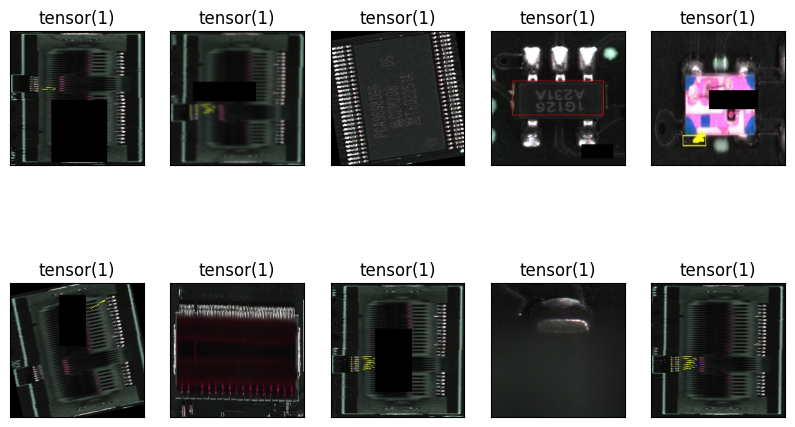

In [10]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

img = images.numpy()
img = img / 2 + 0.5

fig, axes = plt.subplots(2, int(batch_size/2), figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(np.transpose(img[i], (1, 2, 0)))
    ax.set_title(labels[i])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
device

NVIDIA GeForce RTX 3060 Ti


device(type='cuda', index=0)

In [12]:
def train_model(model, loss, optimizer, num_epochs, device):
    '''
        Обучение модели
    '''
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # на каждой эпохе проходим фазу обучения и валидации
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train() # обучение
            else:
                dataloader = val_dataloader
                model.eval() # валидация

            # метрики потерь и точности
            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):

                    # forward
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    # backward в фазе обучения
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                
                # обновление метрик
                running_loss += loss_value.item()
                if phase == 'train':
                    # running_acc += (preds_class == labels.argmax(dim=1)).float().mean()
                    running_acc += (preds_class == labels).float().mean()
                else:
                    running_acc += (preds_class == labels.data).float().mean()

                # scheduler.step()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

        scheduler.step()
        
    # return model

In [13]:
def accuracy_recall_precision(model, dataloader):
    model.eval()
      
    all_predictions = []
    all_labels = []

    #  computing accuracy
    total_correct = 0
    total_instances = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        all_labels.extend(labels)
        predictions = torch.argmax(model(images), dim=1)
        all_predictions.extend(predictions)
        correct_predictions = sum(predictions==labels).item()
        total_correct+=correct_predictions
        total_instances+=len(images)
    accuracy = round(total_correct/total_instances, 4)

    #  computing recall and precision
    true_positives = 0
    false_negatives = 0
    false_positives = 0
    for idx in range(len(all_predictions)):
        if all_predictions[idx].item()==1 and  all_labels[idx].item()==1:
          true_positives+=1
        elif all_predictions[idx].item()==0 and all_labels[idx].item()==1:
          false_negatives+=1
        elif all_predictions[idx].item()==1 and all_labels[idx].item()==0:
          false_positives+=1
    try:
        recall = round(true_positives/(true_positives + false_negatives), 4)
    except ZeroDivisionError:
        recall = 0.0
    try:
        precision = round(true_positives/(true_positives + false_positives), 4)
    except ZeroDivisionError:
        precision = 0.0
    
    return accuracy, recall, precision

def get_predict(model, dataloader):
    test_res = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)
            preds_class = preds.argmax(dim=1)

            test_res.extend(preds_class.tolist())
    
    return test_res

In [12]:
# предобученная модель efficientnet_v2_l
model = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')

# перекладываем модель на device (если есть gpu)
model = model.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.00001, verbose=True)

num_epochs = 10

In [13]:
train_model(model, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/9:


100%|██████████| 4911/4911 [48:13<00:00,  1.70it/s] 

train Loss: 0.0471 Acc: 0.9920



100%|██████████| 655/655 [03:43<00:00,  2.93it/s]

val Loss: 0.0361 Acc: 0.9947
Epoch 1/9:



100%|██████████| 4911/4911 [22:34<00:00,  3.62it/s]

train Loss: 0.0186 Acc: 0.9947



100%|██████████| 655/655 [01:01<00:00, 10.62it/s]

val Loss: 0.0235 Acc: 0.9937
Epoch 2/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0146 Acc: 0.9959



100%|██████████| 655/655 [01:01<00:00, 10.64it/s]

val Loss: 0.0326 Acc: 0.9940
Epoch 3/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.80it/s]

train Loss: 0.0113 Acc: 0.9968



100%|██████████| 655/655 [01:01<00:00, 10.67it/s]

val Loss: 0.0226 Acc: 0.9948
Epoch 4/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0099 Acc: 0.9975



100%|██████████| 655/655 [01:01<00:00, 10.68it/s]

val Loss: 0.0219 Acc: 0.9936
Epoch 5/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0087 Acc: 0.9974



100%|██████████| 655/655 [01:01<00:00, 10.68it/s]

val Loss: 0.0297 Acc: 0.9947
Epoch 6/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0079 Acc: 0.9979



100%|██████████| 655/655 [01:01<00:00, 10.71it/s]

val Loss: 0.0287 Acc: 0.9960
Epoch 7/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0074 Acc: 0.9982



100%|██████████| 655/655 [01:01<00:00, 10.67it/s]

val Loss: 0.0247 Acc: 0.9950
Epoch 8/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0082 Acc: 0.9975



100%|██████████| 655/655 [01:01<00:00, 10.65it/s]

val Loss: 0.0244 Acc: 0.9953
Epoch 9/9:



100%|██████████| 4911/4911 [21:30<00:00,  3.81it/s]

train Loss: 0.0077 Acc: 0.9979



100%|██████████| 655/655 [01:01<00:00, 10.69it/s]

val Loss: 0.0255 Acc: 0.9951


In [14]:
torch.save(model, "./EfV2L_noaug_10e_base_shfld_v1.pt")

In [13]:
# загружаем модель
model_path = '.'
model = torch.load(f'{model_path}/EfV2L_noaug_10e_base_shfld_v1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
accuracy_recall_precision(model, test_dataloader)

100%|██████████| 982/982 [05:00<00:00,  3.27it/s]


(0.996, 0.998, 0.998)

In [10]:
correct = 0
total = 0
test_res = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        preds = model(inputs)
        preds_class = preds.argmax(dim=1)

        total += labels.size(0)
        correct += (preds_class == labels).sum().item()

        test_res.extend(preds_class.tolist())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [09:34<00:00,  1.71it/s]

Accuracy of the network on the 9820 test images: 99.64358452138492 %


In [11]:
len(test_res), list(zip(*np.unique(test_res, return_counts=True)))

(9820, [(0, 69), (1, 9751)])

In [12]:
df_total_test['modelPredict'] = test_res
df_total_test.head(5)

,assemblyRevision,serialNumber,testerName,type,dataFolderName,indictmentType,repairOperator,repairStatus,designator,partId,pinId,defect_name,defect_image,img_folder,modelPredict
0,MBDX86742001B_T,Y1MTB44BYF012,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-04-11-45-38,Billboard,Larisa_VVTS08,1,1:c92,GRM188C80G106KE47D,NaN,"['Billboard', 'BadJoint', 'RowOffset', 'Coplan...",E_4799_1-c92.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1
1,MPLSAS731005D_T,Y0PYD44FWN05W,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-06-15-07-57,BadJoint,Larisa_VVTS08,1,j43,0787280002,NaN,['BadJoint'],E_434_j43.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1
2,MPLSAS731005D_T,Y0PYD44LFR03T,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-04-21-47-04,BadJoint,Svetlana_VVTS08,1,j62,0787280002,NaN,['BadJoint'],E_5001_j62.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1
3,RSRPCI782009B_B,Y1E3B44GAU0PC,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-04-09-45-36,RowOffset,Larisa_VVTS08,1,1:u10,PI3DBS12212AXUAEX,NaN,['RowOffset'],E_4781_1-u10.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1
4,MPLSAS731005D_T,Y0PYD444W706O,D-SMT-AOI-41,IndictmentXML,D-SMT-AOI-41[@$@]2024-03-13-15-32-23,BadJoint,Larisa_VVTS08,1,j61,0787280002,NaN,['BadJoint'],E_1849_j61.jpg,/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/...,1


In [13]:
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_F = df_total_test.loc[df_total_test['modelPredict'] == 0]


df_total_test_TP = df_total_test_T.loc[df_total_test_T['modelPredict'] == df_total_test_T['repairStatus']]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]
df_total_test_TN = df_total_test_F.loc[df_total_test_F['modelPredict'] == df_total_test_F['repairStatus']]
df_total_test_FN = df_total_test_F.loc[df_total_test_F['modelPredict'] != df_total_test_F['repairStatus']]

In [14]:
df_total_test_FP.count(), df_total_test_FN.count(), df_total_test_TN.count()

(assemblyRevision    18
 serialNumber        18
 testerName          18
 type                18
 dataFolderName      18
 indictmentType      18
 repairOperator      18
 repairStatus        18
 designator          18
 partId              18
 pinId                0
 defect_name         18
 defect_image        18
 img_folder          18
 modelPredict        18
 dtype: int64,
 assemblyRevision    17
 serialNumber        17
 testerName          17
 type                17
 dataFolderName      17
 indictmentType      17
 repairOperator      17
 repairStatus        17
 designator          17
 partId              17
 pinId                0
 defect_name         17
 defect_image        17
 img_folder          17
 modelPredict        17
 dtype: int64,
 assemblyRevision    52
 serialNumber        52
 testerName          52
 type                52
 dataFolderName      52
 indictmentType      52
 repairOperator      52
 repairStatus        52
 designator          52
 partId              52
 pinId    

In [15]:
df_total_test_TP.count()

assemblyRevision    9733
serialNumber        9733
testerName          9733
type                9733
dataFolderName      9733
indictmentType      9733
repairOperator      9733
repairStatus        9733
designator          9733
partId              9733
pinId                  0
defect_name         9733
defect_image        9733
img_folder          9733
modelPredict        9733
dtype: int64

In [16]:
df_total_test.loc[df_total_test['repairStatus'] == 0].count()

assemblyRevision    70
serialNumber        70
testerName          70
type                70
dataFolderName      70
indictmentType      70
repairOperator      70
repairStatus        70
designator          70
partId              70
pinId                0
defect_name         70
defect_image        70
img_folder          70
modelPredict        70
dtype: int64

In [17]:
def save_images(df: pd.DataFrame, folder_path: str, too_many_warn = True):
    img_paths = (df['img_folder'] + df['defect_image']).tolist()
    
    if too_many_warn and (len(img_paths) > 200):
        print('Too many files!!! - ', len(img_paths))
        return
    
    cnt = 0
    for img in img_paths:
        if os.path.isfile(img):
            shutil.copy2(img, folder_path + '/' + img.split('/')[-2] + '___' + img.split('/')[-1])
            cnt += 1
        else:
            print('File not found: ', img)
    
    df.to_csv(folder_path+ '/df.csv', index=False)

    print('Input No of images: ', len(img_paths))
    print('Copied No of images: ', cnt)

In [18]:
save_images(df_total_test_FN, './eda/EfV2L_noaug_10e_base_shfld_v1/FalseNegative')

Input No of images:  17
Copied No of images:  17


In [19]:
save_images(df_total_test_FP, './eda/EfV2L_noaug_10e_base_shfld_v1/FalsePositive')

Input No of images:  18
Copied No of images:  18


In [20]:
save_images(df_total_test_TN, './eda/EfV2L_noaug_10e_base_shfld_v1/TrueNegative')

Input No of images:  52
Copied No of images:  52


In [22]:
save_images(df_total_test_TP, './eda/EfV2L_noaug_10e_base_shfld_v1/TruePositive', too_many_warn=False)

Input No of images:  9733
Copied No of images:  9733


In [6]:
df_total_test_TP = pd.read_csv('./eda/EfV2L_noaug_10e_base_shfld_v1/TruePositive/df.csv')
df_total_test_FP = pd.read_csv('./eda/EfV2L_noaug_10e_base_shfld_v1/FalsePositive/df.csv')
df_total_test_FN = pd.read_csv('./eda/EfV2L_noaug_10e_base_shfld_v1/FalseNegative/df.csv')
df_total_test_TN = pd.read_csv('./eda/EfV2L_noaug_10e_base_shfld_v1/TrueNegative/df.csv')

In [23]:
df_total_test_FP['indictmentType'].value_counts()

indictmentType
Coplanarity     7
Left off        2
Skew            2
Lifted lead     1
Missing lead    1
Missing         1
RowOffset       1
Bridging        1
Flipped         1
BadJoint        1
Name: count, dtype: int64

In [24]:
df_total_test_FN['indictmentType'].value_counts()

indictmentType
BadJoint       9
Bridging       5
Coplanarity    1
Missing        1
Extra Part     1
Name: count, dtype: int64

In [25]:
df_total_test_TN['indictmentType'].value_counts()

indictmentType
Missing        13
Skew           12
Lifted lead     9
BadJoint        8
Tombstone       5
Bridging        3
Extra Part      1
Lifted Lead     1
Name: count, dtype: int64

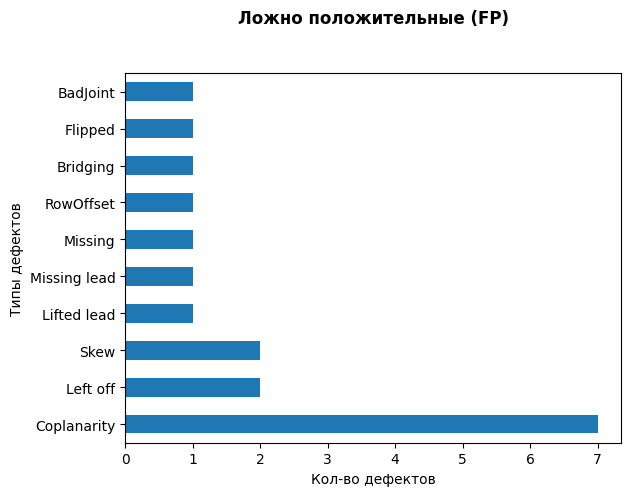

In [7]:
ax = df_total_test_FP['indictmentType'].value_counts().plot(kind='barh')

plt.ylabel('Типы дефектов')
plt.xlabel('Кол-во дефектов')
 
plt.title('Ложно положительные (FP)\n\n',
          fontweight = "bold")

plt.show()

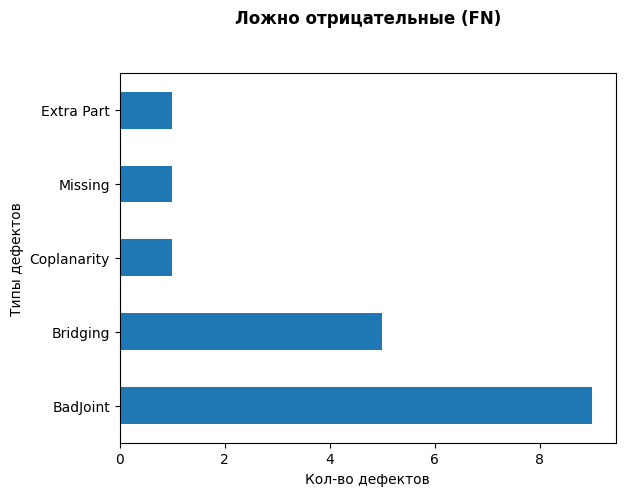

In [9]:
ax = df_total_test_FN['indictmentType'].value_counts().plot(kind='barh')

plt.ylabel('Типы дефектов')
plt.xlabel('Кол-во дефектов')
 
plt.title('Ложно отрицательные (FN)\n\n',
          fontweight = "bold")

plt.show()

In [26]:
df_total_test_TP['indictmentType'].value_counts()

indictmentType
BadJoint           4623
Coplanarity        1175
OCV Fail            836
Bridging            735
RowOffset           533
Polarity            431
Lifted Lead         362
Missing Lead        186
Billboard           160
Extra Part          154
Hor off             151
Left off            123
Right off           114
Missing              88
Skew                 36
Side Camera Err      15
Flipped              10
Damaged               1
Name: count, dtype: int64

Взвешивание классов

In [14]:
weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model0 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')

# перекладываем модель на device (если есть gpu)
model0 = model0.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model0.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [15]:
train_model(model0, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/4911 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4911/4911 [43:56<00:00,  1.86it/s]

train Loss: 0.0469 Acc: 0.9920



100%|██████████| 655/655 [03:04<00:00,  3.54it/s]

val Loss: 0.0213 Acc: 0.9948
Epoch 1/2:



100%|██████████| 4911/4911 [21:17<00:00,  3.85it/s]

train Loss: 0.0193 Acc: 0.9948



100%|██████████| 655/655 [00:59<00:00, 11.00it/s]

val Loss: 0.0243 Acc: 0.9959
Epoch 2/2:



100%|██████████| 4911/4911 [21:18<00:00,  3.84it/s]

train Loss: 0.0134 Acc: 0.9964



100%|██████████| 655/655 [00:59<00:00, 11.00it/s]

val Loss: 0.0332 Acc: 0.9936


In [20]:
accuracy_recall_precision(model0, test_dataloader)

100%|██████████| 982/982 [01:39<00:00,  9.89it/s]


(0.9954, 0.9973, 0.9982)

In [21]:
df_total_test['modelPredict'] = get_predict(model0, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:30<00:00, 10.80it/s]


assemblyRevision    18
serialNumber        18
testerName          18
type                18
dataFolderName      18
indictmentType      18
repairOperator      18
repairStatus        18
designator          18
partId              18
pinId                0
defect_name         18
defect_image        18
img_folder          18
modelPredict        18
dtype: int64

In [22]:
torch.save(model0, "./EfV2L_noaug_model0_v1.pt")

In [14]:
weights1 = torch.FloatTensor([0.9, 0.1]).to(device)
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model1 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')

model1.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model1.classifier[1].in_features, 2),
        )
# перекладываем модель на device (если есть gpu)
model1 = model1.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss(weight = weights1)
# оптимизатор
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [15]:
train_model(model1, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/4911 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4911/4911 [21:41<00:00,  3.77it/s]

train Loss: 0.0907 Acc: 0.9904



100%|██████████| 655/655 [00:59<00:00, 10.99it/s]

val Loss: 0.0615 Acc: 0.9933
Epoch 1/2:



100%|██████████| 4911/4911 [21:36<00:00,  3.79it/s]

train Loss: 0.0438 Acc: 0.9943



100%|██████████| 655/655 [01:01<00:00, 10.73it/s]

val Loss: 0.0737 Acc: 0.9893
Epoch 2/2:



100%|██████████| 4911/4911 [22:02<00:00,  3.71it/s]

train Loss: 0.0299 Acc: 0.9952



100%|██████████| 655/655 [01:01<00:00, 10.64it/s]

val Loss: 0.0633 Acc: 0.9930


In [16]:
accuracy_recall_precision(model1, test_dataloader)

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:40<00:00,  9.76it/s]


(0.9951, 0.9967, 0.9984)

In [19]:

df_total_test['modelPredict'] = get_predict(model1, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:32<00:00, 10.64it/s]


assemblyRevision    16
serialNumber        16
testerName          16
type                16
dataFolderName      16
indictmentType      16
repairOperator      16
repairStatus        16
designator          16
partId              16
pinId                0
defect_name         16
defect_image        16
img_folder          16
modelPredict        16
dtype: int64

In [20]:
torch.save(model1, "./EfV2L_noaug_model1_v1.pt")

In [15]:
weights2 = torch.FloatTensor([0.95, 0.05]).to(device)
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model2 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model2.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model2.classifier[1].in_features, 2),
        )
# перекладываем модель на device (если есть gpu)
model2 = model2.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss(weight = weights2)
# оптимизатор
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [16]:
train_model(model2, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/4911 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4911/4911 [21:59<00:00,  3.72it/s]

train Loss: 0.1170 Acc: 0.9871



100%|██████████| 655/655 [01:01<00:00, 10.65it/s]

val Loss: 0.0667 Acc: 0.9928
Epoch 1/2:



100%|██████████| 4911/4911 [21:47<00:00,  3.76it/s]

train Loss: 0.0583 Acc: 0.9916



100%|██████████| 655/655 [00:59<00:00, 10.97it/s]

val Loss: 0.0842 Acc: 0.9896
Epoch 2/2:



100%|██████████| 4911/4911 [21:52<00:00,  3.74it/s]

train Loss: 0.0388 Acc: 0.9946



100%|██████████| 655/655 [01:00<00:00, 10.75it/s]

val Loss: 0.0874 Acc: 0.9905


In [17]:
accuracy_recall_precision(model2, test_dataloader)

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:40<00:00,  9.81it/s]


(0.9923, 0.9937, 0.9985)

In [18]:
df_total_test['modelPredict'] = get_predict(model2, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:31<00:00, 10.76it/s]


assemblyRevision    15
serialNumber        15
testerName          15
type                15
dataFolderName      15
indictmentType      15
repairOperator      15
repairStatus        15
designator          15
partId              15
pinId                0
defect_name         15
defect_image        15
img_folder          15
modelPredict        15
dtype: int64

In [19]:
torch.save(model2, "./EfV2L_noaug_model2_v1.pt")

In [15]:
weights3 = torch.FloatTensor([0.99, 0.01]).to(device)
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model3 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model3.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model3.classifier[1].in_features, 2),
        )

# перекладываем модель на device (если есть gpu)
model3 = model3.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss(weight = weights3)
# оптимизатор
optimizer = torch.optim.SGD(model3.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [16]:
train_model(model3, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/4911 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4911/4911 [21:45<00:00,  3.76it/s]

train Loss: 0.1406 Acc: 0.9829



100%|██████████| 655/655 [00:59<00:00, 10.97it/s]

val Loss: 0.1837 Acc: 0.9579
Epoch 1/2:



100%|██████████| 4911/4911 [21:43<00:00,  3.77it/s]

train Loss: 0.0732 Acc: 0.9903



100%|██████████| 655/655 [01:01<00:00, 10.68it/s]

val Loss: 0.1482 Acc: 0.9690
Epoch 2/2:



100%|██████████| 4911/4911 [21:57<00:00,  3.73it/s]

train Loss: 0.0487 Acc: 0.9925



100%|██████████| 655/655 [01:01<00:00, 10.66it/s]

val Loss: 0.1252 Acc: 0.9922


In [17]:
accuracy_recall_precision(model3, test_dataloader)


100%|██████████| 982/982 [01:39<00:00,  9.82it/s]


(0.9939, 0.9954, 0.9985)

In [18]:
df_total_test['modelPredict'] = get_predict(model3, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:31<00:00, 10.75it/s]


assemblyRevision    15
serialNumber        15
testerName          15
type                15
dataFolderName      15
indictmentType      15
repairOperator      15
repairStatus        15
designator          15
partId              15
pinId                0
defect_name         15
defect_image        15
img_folder          15
modelPredict        15
dtype: int64

In [19]:
torch.save(model3, "./EfV2L_noaug_model3_v1.pt")

Дублирование

In [21]:
df_total_train1 = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')
df_total_train1['repairStatus'].value_counts()

repairStatus
1    48756
0      350
Name: count, dtype: int64

In [22]:
df_total_train1_false = df_total_train1.loc[df_total_train1['repairStatus'] == 0]
new_rows = pd.concat([df_total_train1_false]*30,ignore_index=True)
df_total_train1 = pd.concat([df_total_train1, new_rows])
df_total_train1['repairStatus'].value_counts()

repairStatus
1    48756
0    10850
Name: count, dtype: int64

In [23]:
train_X = (df_total_train1['img_folder'] + df_total_train1['defect_image']).tolist()
train_y = (df_total_train1['repairStatus']).tolist()

train_dataset1 = image(train_X, train_y, train_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size, shuffle=True, num_workers=0)

In [24]:
weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model4 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model4.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model4.classifier[1].in_features, 2),
        )

# перекладываем модель на device (если есть gpu)
model4 = model4.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model4.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [25]:
train_model(model4, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/5961 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 5961/5961 [25:58<00:00,  3.83it/s]

train Loss: 0.0617 Acc: 0.9766



100%|██████████| 655/655 [01:01<00:00, 10.72it/s]

val Loss: 0.0241 Acc: 0.9931
Epoch 1/2:



100%|██████████| 5961/5961 [26:31<00:00,  3.75it/s]

train Loss: 0.0130 Acc: 0.9963



100%|██████████| 655/655 [00:59<00:00, 10.92it/s]

val Loss: 0.0260 Acc: 0.9947
Epoch 2/2:



100%|██████████| 5961/5961 [25:24<00:00,  3.91it/s]

train Loss: 0.0071 Acc: 0.9981



100%|██████████| 655/655 [01:00<00:00, 10.88it/s]

val Loss: 0.0262 Acc: 0.9937


In [26]:
accuracy_recall_precision(model4, test_dataloader)

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:36<00:00, 10.21it/s]


(0.9967, 0.9984, 0.9984)

In [27]:
df_total_test['modelPredict'] = get_predict(model4, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:28<00:00, 11.13it/s]


assemblyRevision    16
serialNumber        16
testerName          16
type                16
dataFolderName      16
indictmentType      16
repairOperator      16
repairStatus        16
designator          16
partId              16
pinId                0
defect_name         16
defect_image        16
img_folder          16
modelPredict        16
dtype: int64

In [28]:
torch.save(model4, "./EfV2L_noaug_model4_v1.pt")

Добавление аугментациями

In [15]:
df_total_train2 = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')
df_total_train2_0 = df_total_train2.loc[df_total_train2['repairStatus'] == 0]

train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
train_y = (df_total_train['repairStatus']).tolist()

train_X_0_path = (df_total_train2_0['img_folder']).tolist()
train_X_0_imgname = (df_total_train2_0['defect_image']).tolist()

In [16]:
transfomation_random_choice = v2.RandomChoice([
    transforms.RandomHorizontalFlip(1),
    v2.RandomCrop((40, 40)),
    v2.RandomResizedCrop((220, 220)),
    v2.RandomVerticalFlip(1),
    v2.RandomErasing(),
    v2.RandomRotation(degrees=(0,45)),
    v2.ColorJitter(),
    v2.GaussianBlur(9),
    v2.RandomAdjustSharpness(1),
    v2.RandomAutocontrast(1),
    v2.RandomEqualize(1),
])

transfomation_random_order = v2.RandomOrder([
    transforms.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomErasing(),
    v2.ColorJitter(),
    v2.RandomAutocontrast(),
])

In [17]:
from PIL import Image

PATH_FOR_AUG = '/media/ilya/My Passport/HSE/VKR/ML_AOI_helper/rawDATA/aug_images/'
train_X_aug = []
train_y_aug = []

for idx, path in enumerate(train_X_0_path):
    pic = read_image(path + train_X_0_imgname[idx])

    for i in range(30):
        if i < 15:
            pic_trf = transfomation_random_choice(pic)
        if i >= 15:
            pic_trf = transfomation_random_order(pic)

        pic_trf = torchvision.transforms.functional.to_pil_image(pic_trf)
        pic_trf.save(PATH_FOR_AUG + str(i) + '_tsf_' + train_X_0_imgname[idx])
        train_X_aug.append(PATH_FOR_AUG + str(i) + '_tsf_' + train_X_0_imgname[idx])
        train_y_aug.append(0)

len(train_X_aug)

/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


10500

In [18]:
train_X.extend(train_X_aug)
train_y.extend(train_y_aug)

train_dataset = image(train_X, train_y, train_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

len(train_X)

59606

In [19]:
weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model5 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model5.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model5.classifier[1].in_features, 2),
        )

# перекладываем модель на device (если есть gpu)
model5 = model5.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model5.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [20]:
train_model(model5, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/5961 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 5961/5961 [26:21<00:00,  3.77it/s]

train Loss: 0.0332 Acc: 0.9908



100%|██████████| 655/655 [00:59<00:00, 10.93it/s]

val Loss: 0.0332 Acc: 0.9896
Epoch 1/2:



100%|██████████| 5961/5961 [25:32<00:00,  3.89it/s]

train Loss: 0.0146 Acc: 0.9959



100%|██████████| 655/655 [00:59<00:00, 10.98it/s]

val Loss: 0.0312 Acc: 0.9921
Epoch 2/2:



100%|██████████| 5961/5961 [26:01<00:00,  3.82it/s]

train Loss: 0.0103 Acc: 0.9969



100%|██████████| 655/655 [01:01<00:00, 10.65it/s]

val Loss: 0.0286 Acc: 0.9913


In [21]:
accuracy_recall_precision(model5, test_dataloader)

100%|██████████| 982/982 [01:40<00:00,  9.80it/s]


(0.9937, 0.9961, 0.9975)

In [22]:
df_total_test['modelPredict'] = get_predict(model5, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:31<00:00, 10.71it/s]


assemblyRevision    24
serialNumber        24
testerName          24
type                24
dataFolderName      24
indictmentType      24
repairOperator      24
repairStatus        24
designator          24
partId              24
pinId                0
defect_name         24
defect_image        24
img_folder          24
modelPredict        24
dtype: int64

In [23]:
torch.save(model5, "./EfV2L_noaug_model5_v1.pt")

Добавление 0 из другой выборки

In [14]:
df_total_train = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')
df_total_train_add0 = pd.read_csv('./eda/df_total_may_20_true.csv')

df_total_train = pd.concat([df_total_train, df_total_train_add0])

train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
train_y = (df_total_train['repairStatus']).tolist()

df_total_train_add0.count()

assemblyRevision    2010
serialNumber        2010
testerName          2010
type                2010
dataFolderName      2010
indictmentType      2010
repairOperator      2010
repairStatus        2010
designator          2010
partId              2010
pinId                  0
defect_name         2010
defect_image        2010
img_folder          2010
dtype: int64

In [16]:
train_dataset = image(train_X, train_y, train_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
len(train_X)

51116

In [17]:
weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model6 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model6.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model6.classifier[1].in_features, 2),
        )

# перекладываем модель на device (если есть gpu)
model6 = model6.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model6.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [18]:
train_model(model6, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/5112 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 5112/5112 [24:02<00:00,  3.54it/s]

train Loss: 0.0502 Acc: 0.9853



100%|██████████| 655/655 [01:01<00:00, 10.69it/s]

val Loss: 0.0216 Acc: 0.9939
Epoch 1/2:



100%|██████████| 5112/5112 [22:18<00:00,  3.82it/s]

train Loss: 0.0199 Acc: 0.9940



100%|██████████| 655/655 [00:59<00:00, 10.96it/s]

val Loss: 0.0236 Acc: 0.9924
Epoch 2/2:



100%|██████████| 5112/5112 [22:08<00:00,  3.85it/s]

train Loss: 0.0145 Acc: 0.9957



100%|██████████| 655/655 [00:59<00:00, 10.98it/s]

val Loss: 0.0307 Acc: 0.9887


In [19]:
accuracy_recall_precision(model6, test_dataloader)

100%|██████████| 982/982 [01:37<00:00, 10.11it/s]


(0.9921, 0.9937, 0.9982)

In [22]:
df_total_test['modelPredict'] = get_predict(model6, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:30<00:00, 10.85it/s]


assemblyRevision    17
serialNumber        17
testerName          17
type                17
dataFolderName      17
indictmentType      17
repairOperator      17
repairStatus        17
designator          17
partId              17
pinId                0
defect_name         17
defect_image        17
img_folder          17
modelPredict        17
dtype: int64

In [24]:
torch.save(model6, "./EfV2L_noaug_model6_v1.pt")

Комбинация: генерации и добавления из другой

In [22]:
df_total_train1 = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')
df_total_train1['repairStatus'].value_counts()

repairStatus
1    48756
0      350
Name: count, dtype: int64

In [23]:
df_total_train1_false = df_total_train1.loc[df_total_train1['repairStatus'] == 0]
new_rows = pd.concat([df_total_train1_false]*30,ignore_index=True)
df_total_train1 = pd.concat([df_total_train1, new_rows])
df_total_train1['repairStatus'].value_counts()

repairStatus
1    48756
0    10850
Name: count, dtype: int64

In [24]:
df_total_train_add0 = pd.read_csv('./eda/df_total_may_20_true.csv')
df_total_train1 = pd.concat([df_total_train1, df_total_train_add0])

In [25]:
train_X = (df_total_train1['img_folder'] + df_total_train1['defect_image']).tolist()
train_y = (df_total_train1['repairStatus']).tolist()

train_dataset = image(train_X, train_y, train_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
len(train_X)

61616

In [26]:
weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model7 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model7.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model7.classifier[1].in_features, 2),
        )

# перекладываем модель на device (если есть gpu)
model7 = model7.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model7.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [27]:
train_model(model7, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/6162 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 6162/6162 [26:25<00:00,  3.89it/s]

train Loss: 0.0773 Acc: 0.9710



100%|██████████| 655/655 [00:58<00:00, 11.26it/s]

val Loss: 0.0482 Acc: 0.9832
Epoch 1/2:



100%|██████████| 6162/6162 [25:47<00:00,  3.98it/s]

train Loss: 0.0163 Acc: 0.9949



100%|██████████| 655/655 [00:58<00:00, 11.28it/s]

val Loss: 0.0366 Acc: 0.9904
Epoch 2/2:



100%|██████████| 6162/6162 [26:34<00:00,  3.87it/s]

train Loss: 0.0113 Acc: 0.9966



100%|██████████| 655/655 [01:01<00:00, 10.59it/s]

val Loss: 0.0293 Acc: 0.9951


In [28]:
accuracy_recall_precision(model7, test_dataloader)

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:40<00:00,  9.81it/s]


(0.9966, 0.9982, 0.9985)

In [29]:
df_total_test['modelPredict'] = get_predict(model7, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:31<00:00, 10.68it/s]


assemblyRevision    15
serialNumber        15
testerName          15
type                15
dataFolderName      15
indictmentType      15
repairOperator      15
repairStatus        15
designator          15
partId              15
pinId                0
defect_name         15
defect_image        15
img_folder          15
modelPredict        15
dtype: int64

Уменьшение выборки

In [15]:
df_total_train = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')

df_total_train_false = df_total_train.loc[df_total_train['repairStatus'] == 0]
df_total_train_true = df_total_train.loc[df_total_train['repairStatus'] == 1]
df_total_train_true = df_total_train_true.sample(n=3500, random_state=23)

df_total_train = pd.concat([df_total_train_true, df_total_train_false])
df_total_train['repairStatus'].value_counts()

repairStatus
1    3500
0     350
Name: count, dtype: int64

In [16]:
train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
train_y = (df_total_train['repairStatus']).tolist()

train_dataset = image(train_X, train_y, train_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [17]:
weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model8 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model8.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model8.classifier[1].in_features, 2),
        )

# перекладываем модель на device (если есть gpu)
model8 = model8.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model8.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [18]:
train_model(model8, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/385 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 385/385 [01:42<00:00,  3.74it/s]

train Loss: 0.2055 Acc: 0.9179



100%|██████████| 655/655 [01:00<00:00, 10.74it/s]

val Loss: 0.1079 Acc: 0.9466
Epoch 1/2:



100%|██████████| 385/385 [01:43<00:00,  3.73it/s]

train Loss: 0.1184 Acc: 0.9530



100%|██████████| 655/655 [01:00<00:00, 10.74it/s]

val Loss: 0.0684 Acc: 0.9682
Epoch 2/2:



100%|██████████| 385/385 [01:42<00:00,  3.75it/s]

train Loss: 0.0897 Acc: 0.9634



100%|██████████| 655/655 [01:00<00:00, 10.85it/s]

val Loss: 0.0541 Acc: 0.9796


In [19]:
accuracy_recall_precision(model8, test_dataloader)

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:39<00:00,  9.86it/s]


(0.9804, 0.9819, 0.9983)

In [20]:
df_total_test['modelPredict'] = get_predict(model8, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:32<00:00, 10.64it/s]


assemblyRevision    16
serialNumber        16
testerName          16
type                16
dataFolderName      16
indictmentType      16
repairOperator      16
repairStatus        16
designator          16
partId              16
pinId                0
defect_name         16
defect_image        16
img_folder          16
modelPredict        16
dtype: int64

In [21]:
torch.save(model8, "./EfV2L_noaug_model8_v1.pt")

Выбор модели

resnet152

In [15]:
weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model9 = models.resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
# model9.classifier = nn.Sequential(
#             #nn.Dropout(p=0.2, inplace=True),
#             nn.Linear(model9.classifier[1].in_features, 2),
#         )

# перекладываем модель на device (если есть gpu)
model9 = model9.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model9.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [16]:
train_model(model9, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/4911 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4911/4911 [14:22<00:00,  5.69it/s]

train Loss: 0.0659 Acc: 0.9898



100%|██████████| 655/655 [00:52<00:00, 12.57it/s]

val Loss: 0.0373 Acc: 0.9919
Epoch 1/2:



100%|██████████| 4911/4911 [14:21<00:00,  5.70it/s]

train Loss: 0.0215 Acc: 0.9940



100%|██████████| 655/655 [00:51<00:00, 12.65it/s]

val Loss: 0.3276 Acc: 0.9553
Epoch 2/2:



100%|██████████| 4911/4911 [14:10<00:00,  5.77it/s]

train Loss: 0.0155 Acc: 0.9957



100%|██████████| 655/655 [00:51<00:00, 12.79it/s]

val Loss: 0.6716 Acc: 0.9479


In [17]:
accuracy_recall_precision(model9, test_dataloader)

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:17<00:00, 12.75it/s]


(0.9475, 0.9503, 0.9967)

In [18]:
df_total_test['modelPredict'] = get_predict(model9, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:16<00:00, 12.76it/s]


assemblyRevision    31
serialNumber        31
testerName          31
type                31
dataFolderName      31
indictmentType      31
repairOperator      31
repairStatus        31
designator          31
partId              31
pinId                0
defect_name         31
defect_image        31
img_folder          31
modelPredict        31
dtype: int64

In [19]:
torch.save(model9, "./EfV2L_noaug_model9_v1.pt")

convnext_base

In [14]:
weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')
#
model10 = models.convnext_base(weights='ConvNeXt_Base_Weights.IMAGENET1K_V1')
# перекладываем модель на device (если есть gpu)
model10 = model10.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model10.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /home/ilya/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:29<00:00, 12.1MB/s] 


In [15]:
train_model(model10, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/4911 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4911/4911 [30:01<00:00,  2.73it/s]

train Loss: 0.0517 Acc: 0.9922



100%|██████████| 655/655 [01:00<00:00, 10.76it/s]

val Loss: 0.0418 Acc: 0.9930
Epoch 1/2:



100%|██████████| 4911/4911 [29:32<00:00,  2.77it/s]

train Loss: 0.0436 Acc: 0.9929



100%|██████████| 655/655 [00:59<00:00, 10.99it/s]

val Loss: 0.0416 Acc: 0.9930
Epoch 2/2:



100%|██████████| 4911/4911 [29:46<00:00,  2.75it/s]

train Loss: 0.0422 Acc: 0.9929



100%|██████████| 655/655 [00:59<00:00, 10.94it/s]

val Loss: 0.0399 Acc: 0.9929


In [16]:
accuracy_recall_precision(model10, test_dataloader)

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 982/982 [01:29<00:00, 10.97it/s]


(0.9929, 1.0, 0.9929)

In [18]:
df_total_test['modelPredict'] = get_predict(model10, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:29<00:00, 10.96it/s]


assemblyRevision    70
serialNumber        70
testerName          70
type                70
dataFolderName      70
indictmentType      70
repairOperator      70
repairStatus        70
designator          70
partId              70
pinId                0
defect_name         70
defect_image        70
img_folder          70
modelPredict        70
dtype: int64

In [17]:
torch.save(model10, "./EfV2L_noaug_model10_v1.pt")

vit_b_16

In [14]:
model11 = models.vit_b_16(weights='ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1')
model11 = model11.to(device)

model11.img_size = resolution
model11.n_classes = 2
model11.mlp_head_units = resolution

weights = None
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model11.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

num_epochs = 3

In [15]:
train_model(model11, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/4093 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4093/4093 [45:49<00:00,  1.49it/s]

train Loss: 0.0428 Acc: 0.9923



100%|██████████| 546/546 [02:03<00:00,  4.41it/s]

val Loss: 0.0257 Acc: 0.9931
Epoch 1/2:



100%|██████████| 4093/4093 [46:27<00:00,  1.47it/s]

train Loss: 0.0266 Acc: 0.9936



100%|██████████| 546/546 [02:03<00:00,  4.42it/s]

val Loss: 0.0298 Acc: 0.9939
Epoch 2/2:



100%|██████████| 4093/4093 [46:42<00:00,  1.46it/s]

train Loss: 0.0207 Acc: 0.9948



100%|██████████| 546/546 [02:10<00:00,  4.17it/s]

val Loss: 0.0192 Acc: 0.9956


In [16]:
accuracy_recall_precision(model11, test_dataloader)

100%|██████████| 819/819 [03:18<00:00,  4.13it/s]


(0.9958, 0.9988, 0.997)

In [17]:
df_total_test['modelPredict'] = get_predict(model11, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 819/819 [03:12<00:00,  4.26it/s]


assemblyRevision    29
serialNumber        29
testerName          29
type                29
dataFolderName      29
indictmentType      29
repairOperator      29
repairStatus        29
designator          29
partId              29
pinId                0
defect_name         29
defect_image        29
img_folder          29
modelPredict        29
dtype: int64

In [18]:
torch.save(model11, "./EfV2L_noaug_model11_v1.pt")

ОПТИМИЗАЦИЯ

In [14]:
df_total_train_opt1 = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')

df_total_train1_false = df_total_train_opt1.loc[df_total_train_opt1['repairStatus'] == 0]
new_rows = pd.concat([df_total_train1_false]*30,ignore_index=True)
df_total_train_opt1 = pd.concat([df_total_train_opt1, new_rows])

df_total_train_add0 = pd.read_csv('./eda/df_total_may_20_true.csv')
df_total_train_opt1 = pd.concat([df_total_train_opt1, df_total_train_add0])

df_total_train_opt1['repairStatus'].value_counts()

repairStatus
1    48756
0    12860
Name: count, dtype: int64

In [15]:
train_X = (df_total_train_opt1['img_folder'] + df_total_train_opt1['defect_image']).tolist()
train_y = (df_total_train_opt1['repairStatus']).tolist()

train_dataset = image(train_X, train_y, train_transforms)

batch_size = 6

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
len(train_X)

61616

lr = 0.01 model12_1
lr = 0.0001 model12_2
schedule model12_3
augm model12_4
randerase model12_5
decay 0.01 model12_6
decay 0.0001 model12_7
320x320 model12_8

In [17]:
weights12_1 = torch.FloatTensor([0.95, 0.05]).to(device)

#
model12_1 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model12_1.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model12_1.classifier[1].in_features, 2),
        )
# перекладываем модель на device (если есть gpu)
model12_1 = model12_1.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss(weight = weights12_1)
# оптимизатор
optimizer = torch.optim.SGD(model12_1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001, verbose=False)

num_epochs = 3

In [18]:
train_model(model12_1, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/10270 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10270/10270 [41:52<00:00,  4.09it/s]

train Loss: 0.1768 Acc: 0.9048



100%|██████████| 655/655 [01:26<00:00,  7.61it/s]

val Loss: 0.2141 Acc: 0.9301
Epoch 1/2:



100%|██████████| 10270/10270 [41:41<00:00,  4.11it/s]

train Loss: 0.2253 Acc: 0.8938



100%|██████████| 655/655 [01:26<00:00,  7.60it/s]

val Loss: 0.1964 Acc: 0.9452
Epoch 2/2:



100%|██████████| 10270/10270 [41:41<00:00,  4.11it/s]

train Loss: 0.3034 Acc: 0.8576



100%|██████████| 655/655 [01:26<00:00,  7.61it/s]

val Loss: 0.6946 Acc: 0.7832


In [17]:
accuracy_recall_precision(model12_1, test_dataloader)

  0%|          | 0/982 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/982 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 7.76 GiB of which 44.56 MiB is free. Including non-PyTorch memory, this process has 7.23 GiB memory in use. Of the allocated memory 6.94 GiB is allocated by PyTorch, and 135.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
df_total_test['modelPredict'] = get_predict(model12_1, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 982/982 [01:31<00:00, 10.72it/s]


assemblyRevision    12
serialNumber        12
testerName          12
type                12
dataFolderName      12
indictmentType      12
repairOperator      12
repairStatus        12
designator          12
partId              12
pinId                0
defect_name         12
defect_image        12
img_folder          12
modelPredict        12
dtype: int64

In [20]:
torch.save(model12_1, "./EfV2L_model12_8.pt")

In [16]:
model_path = '.'
model = torch.load(f'{model_path}/EfV2L_model12_8.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model12_1 = model

Обучение базовой модели

In [14]:
df_total_train = pd.read_csv('./eda/df_total_train_shuffled_v1.csv')
df_total_val = pd.read_csv('./eda/df_total_val_shuffled_v1.csv')
df_total_test = pd.read_csv('./eda/df_total_test_shuffled_v1.csv')

df_total_train_opt1 = pd.concat([df_total_train, df_total_val, df_total_test])

df_total_train1_false = df_total_train_opt1.loc[df_total_train_opt1['repairStatus'] == 0]
new_rows = pd.concat([df_total_train1_false]*30,ignore_index=True)
df_total_train_opt1 = pd.concat([df_total_train_opt1, new_rows])

df_total_train_add0 = pd.read_csv('./eda/df_total_may_20_true.csv')
df_total_train_opt1 = pd.concat([df_total_train_opt1, df_total_train_add0])

df_total_train_opt1['repairStatus'].value_counts()

repairStatus
1    65006
0    16456
Name: count, dtype: int64

In [15]:
train_X = (df_total_train_opt1['img_folder'] + df_total_train_opt1['defect_image']).tolist()
train_y = (df_total_train_opt1['repairStatus']).tolist()

train_dataset = image(train_X, train_y, train_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
len(train_X)

81462

In [16]:
weights = torch.FloatTensor([0.95, 0.05]).to(device)

#
model12_1 = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
model12_1.classifier = nn.Sequential(
            #nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model12_1.classifier[1].in_features, 2),
        )
# перекладываем модель на device (если есть gpu)
model12_1 = model12_1.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss(weight = weights)
# оптимизатор
optimizer = torch.optim.SGD(model12_1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001, verbose=False)

num_epochs = 10

In [17]:
train_model(model12_1, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/9:


  0%|          | 0/8147 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 8147/8147 [37:36<00:00,  3.61it/s]

train Loss: 0.1570 Acc: 0.8906



100%|██████████| 655/655 [00:59<00:00, 10.92it/s]

val Loss: 0.1122 Acc: 0.9540
Epoch 1/9:



100%|██████████| 8147/8147 [35:54<00:00,  3.78it/s]

train Loss: 0.0745 Acc: 0.9492



100%|██████████| 655/655 [00:59<00:00, 10.93it/s]

val Loss: 0.0678 Acc: 0.9762
Epoch 2/9:



100%|██████████| 8147/8147 [35:53<00:00,  3.78it/s]

train Loss: 0.0535 Acc: 0.9632



100%|██████████| 655/655 [01:00<00:00, 10.88it/s]

val Loss: 0.0535 Acc: 0.9823
Epoch 3/9:



100%|██████████| 8147/8147 [35:53<00:00,  3.78it/s]

train Loss: 0.0509 Acc: 0.9664



100%|██████████| 655/655 [00:59<00:00, 10.93it/s]

val Loss: 0.0498 Acc: 0.9853
Epoch 4/9:



100%|██████████| 8147/8147 [36:16<00:00,  3.74it/s]

train Loss: 0.0451 Acc: 0.9711



100%|██████████| 655/655 [00:59<00:00, 10.93it/s]

val Loss: 0.0515 Acc: 0.9812
Epoch 5/9:



100%|██████████| 8147/8147 [35:54<00:00,  3.78it/s]

train Loss: 0.0467 Acc: 0.9696



100%|██████████| 655/655 [00:59<00:00, 10.94it/s]

val Loss: 0.0419 Acc: 0.9879
Epoch 6/9:



100%|██████████| 8147/8147 [35:22<00:00,  3.84it/s]

train Loss: 0.0491 Acc: 0.9669



100%|██████████| 655/655 [01:01<00:00, 10.61it/s]

val Loss: 0.1919 Acc: 0.9536
Epoch 7/9:



100%|██████████| 8147/8147 [35:05<00:00,  3.87it/s]

train Loss: 0.0539 Acc: 0.9646



100%|██████████| 655/655 [00:58<00:00, 11.22it/s]

val Loss: 0.0650 Acc: 0.9839
Epoch 8/9:



100%|██████████| 8147/8147 [35:13<00:00,  3.85it/s]

train Loss: 0.0474 Acc: 0.9696



100%|██████████| 655/655 [00:58<00:00, 11.18it/s]

val Loss: 0.0304 Acc: 0.9904
Epoch 9/9:



100%|██████████| 8147/8147 [34:49<00:00,  3.90it/s]

train Loss: 0.0650 Acc: 0.9599



100%|██████████| 655/655 [00:58<00:00, 11.20it/s]

val Loss: 0.0725 Acc: 0.9847


In [18]:
torch.save(model12_1, "./EfV2L_model_base_v1.pt")

In [34]:
df_total_test = pd.read_csv('./eda/all_xml_files_may_29.csv')

resolution = (240, 240)  #(384, 384)

test_transforms = transforms.Compose([
    transforms.Resize(resolution),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_X = (df_total_test['img_folder'] + df_total_test['defect_image']).tolist()
test_y = (df_total_test['repairStatus']).tolist()

test_dataset = image(test_X, test_y, test_transforms)

batch_size = 10

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [25]:
model_path = '.'
model = torch.load(f'{model_path}/EfV2L_model_base_v1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [35]:
accuracy_recall_precision(model, test_dataloader)

  0%|          | 0/487 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 487/487 [01:32<00:00,  5.25it/s]


(0.0846, 0.0744, 0.9972)

In [36]:
df_total_test['modelPredict'] = get_predict(model, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 487/487 [00:52<00:00,  9.31it/s]


assemblyRevision    1
serialNumber        1
testerName          1
type                1
dataFolderName      1
indictmentType      1
repairOperator      1
repairStatus        1
designator          1
partId              1
pinId               0
defect_name         1
defect_image        1
img_folder          1
modelPredict        1
dtype: int64

In [14]:
df_total_train = pd.read_csv('./eda/df_total_may_20_pre.csv')
df_total_test = pd.read_csv('./eda/all_xml_files_may_21.csv')

resolution = (240, 240)  #(384, 384)

train_transforms = transforms.Compose([
    transforms.Resize(resolution),
    # transforms.RandomHorizontalFlip(),
    # v2.RandomCrop(size=(224, 224)),
    # v2.RandomResizedCrop(size=(32, 32)),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.equalizer = v2.RandomEqualize(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # transforms.ColorJitter(),
    # transforms.ToTensor(),
    # transforms.RandAugment(num_ops = 2, magnitude = 9),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # transforms.RandomErasing(),
])

val_transforms = transforms.Compose([
    transforms.Resize(resolution),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize(resolution),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
train_y = (df_total_train['repairStatus']).tolist()
train_X = train_X[-20000:-50]
train_y = train_y[-20000:-50]
val_X = train_X[-50:]
val_y = train_y[-50:]
test_X = (df_total_test['img_folder'] + df_total_test['defect_image']).tolist()
test_y = (df_total_test['repairStatus']).tolist()

train_dataset = image(train_X, train_y, train_transforms)
val_dataset = image(val_X, val_y, val_transforms)
test_dataset = image(test_X, test_y, test_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
len(train_X)

19950

In [15]:
#
model_path = '.'
model21 = torch.load(f'{model_path}/EfV2L_model_base_v1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model21 = model21.to(device)

weights = torch.FloatTensor([0.95, 0.05]).to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss(weight = weights)
# оптимизатор
optimizer = torch.optim.SGD(model21.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001, verbose=False)

num_epochs = 3

In [16]:
train_model(model21, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/2:


  0%|          | 0/1995 [00:00<?, ?it/s]/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1995/1995 [12:49<00:00,  2.59it/s]

train Loss: 0.3443 Acc: 0.9517



100%|██████████| 5/5 [00:00<00:00, 14.74it/s]

val Loss: 0.7620 Acc: 0.9600
Epoch 1/2:



100%|██████████| 1995/1995 [08:20<00:00,  3.99it/s]

train Loss: 0.2129 Acc: 0.9773



100%|██████████| 5/5 [00:00<00:00, 14.85it/s]

val Loss: 1.1406 Acc: 0.6600
Epoch 2/2:



100%|██████████| 1995/1995 [08:17<00:00,  4.01it/s]

train Loss: 0.1922 Acc: 0.9785



100%|██████████| 5/5 [00:00<00:00, 15.08it/s]

val Loss: 0.6698 Acc: 0.9600


In [18]:
accuracy_recall_precision(model21, test_dataloader)

100%|██████████| 680/680 [02:11<00:00,  5.15it/s]


(0.9302, 0.941, 0.9874)

In [19]:
df_total_test['modelPredict'] = get_predict(model21, test_dataloader)
df_total_test_T = df_total_test.loc[df_total_test['modelPredict'] == 1]
df_total_test_FP = df_total_test_T.loc[df_total_test_T['modelPredict'] != df_total_test_T['repairStatus']]

df_total_test_FP.count()

100%|██████████| 680/680 [01:11<00:00,  9.46it/s]


assemblyRevision    80
serialNumber        80
testerName          80
type                80
dataFolderName      80
indictmentType      80
repairOperator      80
repairStatus        80
designator          80
partId              80
pinId                0
defect_name         80
defect_image        80
img_folder          80
modelPredict        80
dtype: int64

In [20]:
torch.save(model21, "./EfV2L_model_base_20-21.pt")